# Figure notebook

Author: _Pim Dankloff_

Dependencies:

In [6]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection._mutual_info import mutual_info_regression
from scipy.optimize import root_scalar, minimize

# custom anlysis scripts
from analysis.models import szyszkowski_model, dynamic_st_model, szyszkowski
from analysis.utils import fit_model, calculate_st_at_cmc, calculate_C20
from utils.data_processing import smooth
from analysis.mixtures import fit_beta, mix_ideal, mix_non_ideal

## Figure 1

### illustration isotherm

import data & fit model

In [ ]:
df = pd.read_csv("data/example_experimental_isotherm/SDS.csv")
c = df["Concentration"] / 1000
st = df["Surface Tension"] / 1000
obs = (c, st)
parameters = ["cmc", "gamma_max", "Kad"]

# fit isotherm model
post_pred_1, x_new_1 = fit_model(
    obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
)

# unit conversion
x_new_1 = x_new_1 * 1000
x_obs_1, y_obs_1 = obs
x_obs_1 = x_obs_1 * 1000
y_obs_1 = y_obs_1 * 1000

# mean and std of posterior predictive distribution
st_fit_mu = post_pred_1["obs"].mean(axis=0) * 1000
st_fit_std_1 = post_pred_1["obs"].std(axis=0) * 1000

plot isotherm

In [ ]:
fig, ax1 = plt.subplots(figsize=(3, 3))
ax1.plot(x_new_1, st_fit_mu, c="black", alpha=0.3, linewidth=2)
ax1.scatter(
    x_obs_1,
    y_obs_1,
    s=25,
    zorder=100,
    color="black",
    marker="x",
    alpha=1,
)


# axes settings
fontsize_labels = 10

ax1.set_ylim(35, 75)
ax1.set_yticks(np.arange(30, 76, 10))
ax1.set_xlim(0.1, 30)
ax1.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
ax1.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax1.set_xscale("log")
sns.despine()

# save
fig.savefig(
    "figures/figure1/example_isotherm.svg",
    dpi=300,
    bbox_inches="tight",

)

## Figure 2

### Dynamic surface tension example

Import data & fit model

In [2]:
# import data
df = pd.read_csv("data/example_dynamic_surface_tension/C12E4_46mM.csv")
t = df["Time (s)"].values
st = df["Surface Tension (mN/m)"].values

# we slice the data to remove no (hanging) droplet region
idx = np.argmax(st) + 1
t = t[idx:]
st = st[idx:]

# # # fit kinetic model
# obs = (t, st)
# parameters = ["st_messo", "t_star", "n"]
# post_pred_1, x_new_1 = fit_model(
#     obs, model=dynamic_st_model, parameters=parameters, outlier_check=False
# )

Plot dynamic surface tension

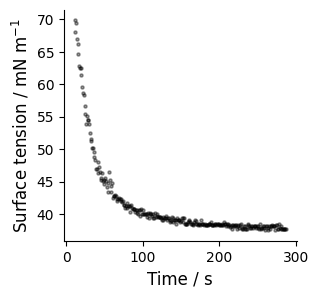

In [3]:
# figure
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()

# plot data and fit
ax.scatter(t, st, label="data", s=5, color="black", alpha=0.4)
# ax.plot(x_new_1, post_pred_1["obs"].mean(axis=0), label="fit", color="black", linewidth=1)

# labels
fontsize_labels = 12
ax.set_xlabel("Time / s", fontsize=fontsize_labels)
ax.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)

# save
fig.savefig(
    "figures/figure2/dynamic_surface_tension.svg", dpi=300, bbox_inches="tight"
)

## Figure 3

### Active learning illustration

Import data, fit model and calculate mutual information

In [ ]:
df = pd.read_csv("data/example_experimental_isotherm/SDS.csv")
c = df["Concentration"] / 1000
st = df["Surface Tension"] / 1000
obs = (c, st)
parameters = ["cmc", "gamma_max", "Kad"]

# fit isotherm model
post_pred_1, x_new_1 = fit_model(
    obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
)

# unit conversion
x_new_1 = x_new_1 * 1000
x_obs_1, y_obs_1 = obs
x_obs_1 = x_obs_1 * 1000
y_obs_1 = y_obs_1 * 1000

# mean and std of posterior predictive distribution
st_fit_mu = post_pred_1["obs"].mean(axis=0) * 1000
st_fit_std_1 = post_pred_1["obs"].std(axis=0) * 1000

# extract mutual information
mutual_info = {}
U_total = np.zeros(post_pred_1["obs"].shape[1])
for parameter in parameters:
    U = smooth(
        mutual_info_regression(post_pred_1["obs"], post_pred_1[parameter]),
        window_size=30,
    )
    U_total += U
    mutual_info[parameter] = U

mutual_info["total"] = U_total

Plot experimental isotherm and mutual information relations

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
ax1.plot(x_new_1, st_fit_mu, c="black", alpha=0.3, linewidth=2)
ax1.scatter(
    x_obs_1,
    y_obs_1,
    s=25,
    zorder=100,
    color="black",
    marker="o",
    alpha=1,
)

# plot mutual information
linewidth_mi = 2 
label_convert_dict = {
    "cmc": "CMC",
    "gamma_max": r"$\Gamma_{\max}$",
    "Kad": r"K$_{\mathrm{L}}$",
}
for parameter in parameters:
    ax2.plot(
        x_new_1,
        mutual_info[parameter],
        label=label_convert_dict[parameter],
        zorder=10,
        alpha=0.5,
        linewidth=linewidth_mi,
    )
ax2.plot(x_new_1, U_total, label="total", alpha=0.5, linewidth=linewidth_mi)


# axes settings
fontsize_labels = 10

ax1.set_ylim(35, 80)
ax2.set_xlim(0.1, 30)
ax1.set_xlim(0.1, 30)
ax2.set_xscale("log")
ax2.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax2.set_ylabel(r"Mutual information", fontsize=fontsize_labels)
ax1.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
ax2.legend(fontsize=10, loc="upper left", frameon=False)

sns.despine()

# save
fig.savefig(
    "figures/figure3/active_learning.svg",
    dpi=300,
    bbox_inches="tight",
)

### Model uncertainty on fitting parameters per round of AL

Import data and fit model

In [5]:
df = pd.read_csv(f"data/example_al_cycles/results.csv")
print(f"len df: {len(df)}")
df_explore = df[df["point type"] == "explore"]
print(f"len explore: {len(df_explore)}")
df_exploit = df[df["point type"] == "exploit"]
print(f"len exploit: {len(df_exploit)}")

c = df_explore["concentration"].to_numpy() / 1000
st = df_explore["surface tension eq. (mN/m)"].to_numpy() / 1000
obs = (c, st)
parameters = ["cmc", "gamma_max", "Kad"]

cmc_errors = []
gamma_max_errors = []
kad_errors = []

len_exploit = 4
for i in range(len_exploit+1):
    # fit isotherm model
    post_pred, x_new = fit_model(
        obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
    )
    cmc_errors.append(post_pred["cmc"].std(axis=0) / post_pred["cmc"].mean(axis=0) * 100)
    gamma_max_errors.append(
        post_pred["gamma_max"].std(axis=0) / post_pred["gamma_max"].mean(axis=0) * 100
    )
    print(post_pred["gamma_max"].mean(axis=0))
    kad_errors.append(post_pred["Kad"].std(axis=0) / post_pred["Kad"].mean(axis=0) * 100)

    # add explore points to obs
    if i != len_exploit:
        c = np.append(c, df_exploit.iloc[i]["concentration"] / 1000)
        st = np.append(st, df_exploit.iloc[i]["surface tension eq. (mN/m)"] / 1000)
        obs = (c, st)
        

len df: 60
len explore: 3
len exploit: 4


sample: 100%|██████████| 1500/1500 [00:03<00:00, 470.12it/s, 3 steps of size 1.04e-02. acc. prob=0.38] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    366.69     21.31    368.81    329.78    399.08     89.02      1.02
        cmc      0.00      0.00      0.00      0.00      0.00     96.99      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00     89.23      1.03
      sigma      0.00      0.00      0.00      0.00      0.00      4.77      1.77

Number of divergences: 236
3.2564923e-05


sample: 100%|██████████| 1500/1500 [00:02<00:00, 532.41it/s, 23 steps of size 8.24e-02. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   2061.72    206.68   2059.74   1719.96   2360.57    358.93      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    365.33      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    341.63      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    373.74      1.00

Number of divergences: 0
8.558844e-06


sample: 100%|██████████| 1500/1500 [00:03<00:00, 485.16it/s, 19 steps of size 1.13e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   2236.42    167.99   2221.25   1980.46   2523.36    224.52      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    349.30      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    202.92      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    374.16      1.00

Number of divergences: 0
8.192008e-06


sample: 100%|██████████| 1500/1500 [00:03<00:00, 384.99it/s, 23 steps of size 8.29e-02. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   2244.48    168.32   2239.42   1961.26   2507.04    255.59      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    270.74      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    242.22      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    435.24      1.00

Number of divergences: 0
8.173437e-06


sample: 100%|██████████| 1500/1500 [00:03<00:00, 456.42it/s, 31 steps of size 6.58e-02. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   1544.46    169.07   1535.93   1254.38   1779.83    365.44      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    391.56      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    350.84      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    371.43      1.00

Number of divergences: 0
1.0072639e-05


Plot

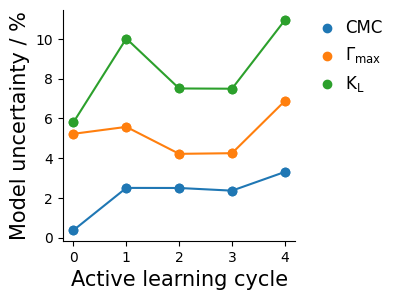

In [4]:
fig, ax = plt.subplots(figsize = (3, 3))

AL_cycles = [0, 1, 2, 3, 4]
plt.plot(AL_cycles, cmc_errors, marker='o')
plt.plot(AL_cycles, gamma_max_errors, marker='o')
plt.plot(AL_cycles, kad_errors, marker="o")

plt.scatter(AL_cycles, cmc_errors, marker="o", label="CMC")
plt.scatter(AL_cycles, gamma_max_errors, marker="o", label="$\Gamma_{\mathrm{max}}$")
plt.scatter(AL_cycles, kad_errors, marker="o", label="K$_\mathrm{L}$")

fontsize_labels = 15
plt.xlabel("Active learning cycle", fontsize = fontsize_labels)
plt.ylabel("Model uncertainty / %", fontsize = fontsize_labels)

# plt.ylim(0, 8)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.8), frameon=False, fontsize=12, handletextpad=0.1)
sns.despine()

# plt.tight_layout()
# plt.savefig(
#     "figures/figure3/model_uncertainty.svg",
#     dpi=300,
#     bbox_inches="tight",
# )


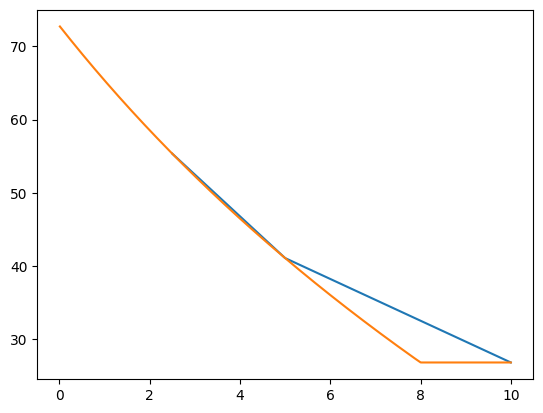

In [13]:
# define true parameters
cmc = 8 / 1000
gamma_max = 3.2e-5
Kad = 100

theta_true = (cmc, gamma_max, Kad)

explore_concentrations = [10, 5, 2.5]
fit_concentrations = np.linspace(0.01, 10, 1000)
explore_st = []
fit_st = []
for c in explore_concentrations:
    c = c / 1000
    explore_st.append(szyszkowski(cS0=c, theta=theta_true)*1000)

for c in fit_concentrations:
    c = c / 1000
    fit_st.append(szyszkowski(cS0=c, theta=theta_true)*1000)

plt.plot(explore_concentrations, explore_st)
plt.plot(fit_concentrations, fit_st)

## Figure 4

import data and fit model

In [ ]:
# List of (experiment_tag, solution) pairs
isotherms_ids = [
    ("AULAB_PSP0076/part_3", "SDBS_1_1"),
    ("AULAB_PSP0073", "CTAB"),
    ("AULAB_PSP0076/part_7", "C12E3_1_3"),
    ("AULAB_PSP0076/part_4", "SDS_2_1"),
    ("AULAB_PSP0076/part_7", "16BAC_1_2"),
    ("AULAB_PSP0076/part_6", "C12E4_1_1"),
]

parameters = ["cmc", "gamma_max", "Kad"]

fit_results = []
for experiment_tag, solution in isotherms_ids:
    results = pd.read_csv(f"data/experiments/{experiment_tag}/results.csv")
    results_solution = results[results["solution"] == solution]
    point_types = results_solution["point type"]

    c = results_solution["concentration"] / 1000
    st = results_solution["surface tension eq. (mN/m)"] / 1000
    obs = (c, st)
    print(f"Fitting model for {solution} in {experiment_tag}...")
    post_pred, x_new = fit_model(
        obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
    )
    x_new = x_new * 1000
    x_obs, y_obs = obs
    x_obs = x_obs * 1000
    y_obs = y_obs * 1000
    st_fit_mean = post_pred["obs"].mean(axis=0) * 1000
    st_fit_std = post_pred["obs"].std(axis=0) * 1000

    fit_results.append(
        {
            "experiment_tag": experiment_tag,
            "solution": solution,
            "point_types": point_types,
            "x_new": x_new,
            "x_obs": x_obs,
            "y_obs": y_obs,
            "st_fit_mean": st_fit_mean,
            "st_fit_std": st_fit_std,
            "post_pred": post_pred,
        }
    )

plot the isotherms

In [ ]:
# Suppose fit_results is a list of dicts as in the previous answer
n_isotherms = len(fit_results)
ncols = 3
nrows = int(np.ceil(n_isotherms / ncols))
fig, axes = plt.subplots(
    nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), squeeze=False
)

fontsize_labels = 10
axes = axes.flatten()  # Flatten for easy iteration

titles = ["SDBS", "CTAB", "C$_{12}$E$_{3}$", "SDS", "16-BAC", "C$_{12}$E$_{4}$"]

for i, (ax, fit) in enumerate(zip(axes, fit_results)):
    point_types = fit["point_types"]
    explore_mask = point_types == "explore"
    exploit_mask = point_types == "exploit"
    x_new = fit["x_new"]
    st_fit_mean = fit["st_fit_mean"]
    x_obs = fit["x_obs"]
    y_obs = fit["y_obs"]

    # Plot fit
    ax.plot(
        x_new,
        st_fit_mean,
        color="black",
        alpha=0.3,
        linewidth=2,
        label="fit",
    )
    # Plot explore points
    ax.scatter(
        x_obs[explore_mask],
        y_obs[explore_mask],
        s=25,
        zorder=100,
        color="black",
        marker="o",
        alpha=1,
        label="explore" if i == 0 else None,
    )
    # Plot exploit points
    ax.scatter(
        x_obs[exploit_mask],
        y_obs[exploit_mask],
        s=25,
        zorder=100,
        color="black",
        marker="x",
        alpha=1,
        label="exploit" if i == 0 else None,
    )

    ax.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
    ax.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
    ax.set_ylim(25, 75)
    ax.set_xlim(0.001, 15)
    ax.set_xscale("log")
    if "solution" in fit:
        title = titles[i]
        ax.set_title(title, fontsize=fontsize_labels)

# Hide unused subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

sns.despine()
plt.tight_layout()
fig.savefig(
    "figures/figure4/isotherm_examples.svg",
    dpi=300,
    bbox_inches="tight",
)

## Figure 5 & SI

### mixture space exploration
select mixture in the first rule for the particular mixture

import data & fit model

In [2]:
# input
mixture = "SOS_SDS"
folder = "figureS4"

results = pd.read_csv(f"data/mixture/{mixture}/mixture_data_{mixture}.csv")
alphas = results["alpha"].unique()
parameters = ["cmc", "gamma_max", "Kad"]
fit_results = {}
for alpha in alphas:
    print(f"Fitting for alpha = {alpha}")
    results_alpha = results[results["alpha"] == alpha]
    c = results_alpha["concentration"] / 1000
    st = results_alpha["surface tension eq. (mN/m)"] / 1000
    obs = (c, st)
    post_pred, x_new = fit_model(
        obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
    )
    fit_results[alpha] = {
        "post_pred": post_pred,
        "x_new": x_new,
    }
    print("done fitting for alpha =", alpha)

Fitting for alpha = 0.0


sample: 100%|██████████| 1500/1500 [00:02<00:00, 557.12it/s, 59 steps of size 4.14e-02. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    204.31     19.19    203.69    170.37    232.91    316.04      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    444.07      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    266.29      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    412.51      1.00

Number of divergences: 0
done fitting for alpha = 0.0
Fitting for alpha = 0.145


sample: 100%|██████████| 1500/1500 [00:02<00:00, 596.01it/s, 127 steps of size 2.00e-02. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     86.01     21.48     87.99     53.26    121.94    209.79      1.01
        cmc      0.01      0.00      0.01      0.01      0.01    182.30      1.01
  gamma_max      0.00      0.00      0.00      0.00      0.00    134.69      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    299.87      1.00

Number of divergences: 0
done fitting for alpha = 0.145
Fitting for alpha = 0.311


sample: 100%|██████████| 1500/1500 [00:02<00:00, 513.09it/s, 67 steps of size 2.75e-02. acc. prob=0.95]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     76.35     14.12     76.05     53.39     98.70    215.05      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    333.86      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    197.50      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    499.87      1.00

Number of divergences: 0
done fitting for alpha = 0.311
Fitting for alpha = 0.504


sample: 100%|██████████| 1500/1500 [00:02<00:00, 513.40it/s, 255 steps of size 8.28e-03. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     24.46     11.14     23.92      7.21     43.78    229.57      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    219.76      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    149.60      1.01
      sigma      0.00      0.00      0.00      0.00      0.00    342.64      1.01

Number of divergences: 0
done fitting for alpha = 0.504
Fitting for alpha = 0.731


sample: 100%|██████████| 1500/1500 [00:03<00:00, 492.41it/s, 127 steps of size 1.84e-02. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     26.37      7.34     26.41     17.07     39.65     63.91      1.00
        cmc      0.02      0.00      0.02      0.01      0.02     75.96      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00     58.77      1.02
      sigma      0.00      0.00      0.00      0.00      0.00    306.20      1.00

Number of divergences: 0
done fitting for alpha = 0.731
Fitting for alpha = 1.0


sample: 100%|██████████| 1500/1500 [00:03<00:00, 478.30it/s, 23 steps of size 6.29e-02. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     75.94      6.41     75.28     66.06     86.66    184.03      1.00
        cmc      0.11      0.01      0.11      0.11      0.13    107.91      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    151.01      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    317.63      1.00

Number of divergences: 0
done fitting for alpha = 1.0


Extract properties

In [4]:
data = []
alphas = results["alpha"].unique()

for alpha, fit in fit_results.items():
    row = [alpha]
    for parameter in parameters:
        if parameter == "cmc":
            row.append(fit["post_pred"][parameter].mean(axis=0) * 1000)
        else:
            row.append(fit["post_pred"][parameter].mean(axis=0))

    # Calculate st_at_cmc
    st_at_cmc = calculate_st_at_cmc(
        fit["x_new"], fit["post_pred"]
    )
    row.append(st_at_cmc * 1000)  # Convert to mN/m

    # Calculate C20
    c20 = calculate_C20(fit["x_new"], fit["post_pred"])
    row.append(c20)  # C20 in mM
    
    data.append(row)


columns = ["alpha"] + parameters + ["st_at_cmc"] + ["C20"]

df_properties = pd.DataFrame(data, columns=columns)
print(df_properties)

   alpha        cmc      gamma_max        Kad  st_at_cmc        C20
0  0.000   7.419878  1.5437614e-05  204.30795   38161.15  4.0901246
1  0.145  7.9376483  2.9370998e-05   86.00678   38218.22   4.761776
2  0.311   9.125566  2.8098011e-05   76.34813  37506.656  5.3551593
3  0.504  10.419728  9.8294644e-05  24.464697  37613.316  6.5063524
4  0.731  15.168169  5.3732972e-05  26.365866  35964.805   8.775991
5  1.000  114.77995  5.8655482e-06    75.9421   40285.59  51.799156


Plot isotherms

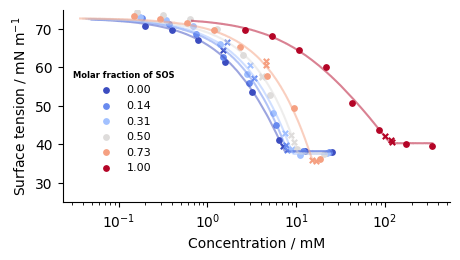

In [5]:
fig, ax = plt.subplots(figsize=(5, 2.5))
size_marker = 15

# Normalize alpha values for colormap
alphas = results["alpha"].unique()
norm = plt.Normalize(alphas.min(), alphas.max())
cmap = plt.cm.coolwarm

scatter_handles = []
for alpha in alphas:
    color = cmap(norm(alpha))
    results_alpha = results[results["alpha"] == alpha]
    fit_alpha = fit_results[alpha]
    point_types = results_alpha["point type"]
    explore_mask = point_types == "explore"
    exploit_mask = point_types == "exploit"
    x_obs = results_alpha["concentration"]
    y_obs = results_alpha["surface tension eq. (mN/m)"]
    handle = ax.scatter(
        x_obs[explore_mask],
        y_obs[explore_mask],
        color=color,
        marker="o",
        zorder=15,
        s=size_marker,
        label=f"{alpha:.2f}",
    )
    scatter_handles.append(handle)
    ax.scatter(
        x_obs[exploit_mask],
        y_obs[exploit_mask],
        color=color,
        marker="x",
        s=size_marker,
        zorder=15,
    )
    x_new = fit_alpha["x_new"] * 1000
    st_fit_mean = fit_alpha["post_pred"]["obs"].mean(axis=0) * 1000  # Convert to mN/m
    ax.plot(x_new, st_fit_mean, c=color, alpha=0.5, zorder=20)

ax.set_xscale("log")
ax.set_ylim(25, 75)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add legend for alpha colors
ax.legend(
    handles=scatter_handles,
    title="Molar fraction of SOS",
    # title_fontsize=6,
    title_fontproperties={"weight": "bold", "size": 6},
    fontsize=8,
    loc="lower left",
    bbox_to_anchor=(0, 0.1),
    frameon=False,
)
fontsize_labels = 10
ax.set_xlabel("Concentration / mM", fontsize=10)
ax.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=10)
sns.despine()

# save
fig.savefig(
    f"figures/{folder}/mixture_isotherm.svg",
    dpi=300,
    bbox_inches="tight",
)

interaction parameter plot: micellization 

Fitted interaction parameter β: -1.1530


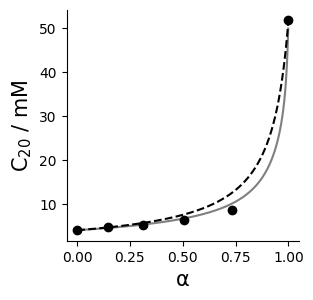

In [13]:
property = "C20" # options: cmc or C20

alpha_list = df_properties["alpha"].to_list()
c_mix_list = df_properties[property].to_list()

c1 = c_mix_list[-1]
c2 = c_mix_list[0]

fitted_beta = fit_beta(alpha_obs=alpha_list, c_mix_obs=c_mix_list)
alpha_fit = np.linspace(0.001, 0.999, 1000)
c_mix_ideal_list = []
c_mix_nonideal_list = []
for alpha in alpha_fit:
    c_mix_ideal = mix_ideal(c1=c1, c2=c2, alpha=alpha)
    c_mix_ideal_list.append(c_mix_ideal)
    c_mix_nonideal = mix_non_ideal(c1=c1, c2=c2, c_mix=c_mix_ideal, alpha=alpha, beta=fitted_beta)
    c_mix_nonideal_list.append(c_mix_nonideal)

# # Plotting
plt.figure(figsize=(3, 3))
plt.plot(
    alpha_fit,
    c_mix_nonideal_list,
    label="Non-Ideal",
    color="black",
    alpha=0.5,
)

plt.plot(
    alpha_fit, c_mix_ideal_list, label="Ideal", color="black", linestyle="--"
)
plt.scatter(
    alpha_list,
    c_mix_list,
    label="Experimental Data",
    zorder=30,
    color="black",
)

# plot settings
sns.despine()
fontsize_labels = 15
plt.xlabel(r"$\mathrm{\alpha}$", fontsize=fontsize_labels)
if property == "cmc":
    plt.ylabel("CMC$_{\mathrm{mix}}$ / mM", fontsize=fontsize_labels)
elif property == "C20":
    plt.ylabel("C$_{\mathrm{20}}$ / mM", fontsize=fontsize_labels)


# save
# plt.savefig(
#     f"figures/{folder}/{property}_interaction.svg",
#     dpi=300,
#     bbox_inches="tight",
# )

# Supplementary Figures

### Worthington number dependency on volume of pendant drop

In [ ]:
# import data
df = pd.read_csv("data/worthington_dropvolume/water.csv")
wo = df["Wo"]
vol = df["drop volume (uL)"]

# figure
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()

# plot experimental data + horizontal limit
ax.scatter(vol, wo, s=10, color="black", alpha=0.5)
ax.axhline(y=0.6, color="black", linestyle="--")

# labels
fontsize_labels = 12
ax.set_xlabel(r"Drop volume / $\mathrm{\mu L}$", fontsize=fontsize_labels)
ax.set_ylabel(r"Worthington number", fontsize=fontsize_labels)

# limits
ax.set_xlim(3, 7)
ax.set_ylim(-0.05, 1)

# save
# fig.savefig("figures/figure2/worthington_dropvolume.svg", dpi=figure_dpi, bbox_inches="tight")

### Comparison pendant drop measurements with literature values

In [ ]:
# import data
df = pd.read_csv("data/comparison_pendantprop_literature/data.csv")
df_water = df[df["solution"] == "water"]
df_SDS = df[df["solution"] == "SDS"]
water_mu = df_water["needle mu"].values[0]
water_std = df_water["needle std"].values[0]
SDS_mu = df_SDS["needle mu"].values[0]
SDS_std = df_SDS["needle std"].values[0]

# Experimental values
labels = ["Water", "SDS 34 mM"]
means = [water_mu, SDS_mu]
stds = [water_std, SDS_std]

# Literature values
lit_labels = ["Water (lit)", "SDS (lit)"]
lit_means = [72.2, 38]  # mN/m

# Combine labels and values for plotting
all_labels = labels + lit_labels
all_means = means + lit_means
all_stds = stds + [0, 0]  # No error bars for literature values

# Create a bar graph with error bars
plt.figure(figsize=(3, 3))

bar_width = 1  # Width of each bar
group_spacing = 1  # Spacing between groups

# Plot experimental values
x_exp = np.arange(len(labels)) * (2 * bar_width + group_spacing)
plt.bar(
    x_exp, means, yerr=stds, capsize=5, color="skyblue", alpha=0.8, label="Experimental"
)

# Plot literature values
x_lit = x_exp + bar_width
plt.bar(x_lit, lit_means, color="orange", alpha=0.8, label="Literature")

# Add labels and legend
fontsize_labels = 12
plt.xticks(
    x_exp + bar_width / 2, labels, fontsize=fontsize_labels
)  # Increased font size for x labels
plt.ylabel(
    "Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels
)  # Increased font size for y-axis label
plt.legend(fontsize=8)  # Increased font size for legend
sns.despine()

# save
plt.savefig(
    "figures/figureS3/surface_tension_comparison.svg",
    dpi=300,
    bbox_inches="tight",
)

### Precision evaluation

In [ ]:
exp_tag = "AULAB_PSP0076/part_4" #SDS
df = pd.read_csv(f"data/experiments/{exp_tag}/results.csv")
df_explore = df[df["point type"] == "explore"]
df_explore_agg = (
    df_explore.groupby("concentration")["surface tension eq. (mN/m)"]
    .agg(["mean", "std"])
    .reset_index()
)

c = df_explore_agg["concentration"]
st_mu = df_explore_agg["mean"]
st_std = df_explore_agg["std"]

# # plot mean surface tension vs concentration with error bars
fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    c,
    st_mu,
    yerr=2 * st_std,
    fmt="o",
    label="Mean",
    color="black",
    markersize=5,
    capsize=3,
)

# plot settings
ax.set_xscale("log")
fontsize_labels = 11
ax.set_xlabel("concentration / mM", fontsize=fontsize_labels)
plt.ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
# ax.set_ylim(35, 75)
sns.despine()
plt.tight_layout()

plt.savefig("figures/figureS3/precision.svg", dpi=300)

### Accuracy evaluation

In [ ]:
# pendant drop
df = pd.read_csv(f"data/eval_accuracy/A_long.csv")
c_pendant = df["Concentration"]
st_pendant = df["Surface Tension"]

# du nuoy ring
df = pd.read_excel("data/eval_accuracy/PSP0058_total_data.xlsx")
c_tensio = df["concentration (mM)"]
st_tensio = df["st tensiometer (mN/m)"]

# plot surface tension vs concentration, both methods
fig, ax = plt.subplots(figsize=(3, 3))

# pendant drop
ax.scatter(
    c_pendant,
    st_pendant,
    color="C0",
    s=50,
    label=f"Robotic Pendant Drop",
    alpha=0.5,
)

# du nouy ring
ax.scatter(
    c_tensio,
    st_tensio,
    color="C1",
    label="D$\mathrm{\ddot{u}}$ Nouy ring",
    s=50,
    marker="o",
    alpha=0.5,
)

# plot settings
ax.legend(fontsize=6)
ax.set_xscale("log")
fontsize_labels = 11
ax.set_xlabel("concentration / mM", fontsize=fontsize_labels)
plt.ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)

ax.set_ylim(35, 75)
sns.despine()
plt.tight_layout()

plt.savefig("figures/figureS3/accuracy.svg", dpi=300)